In [1]:
!pip install -q torch transformers open_clip_torch accelerate bitsandbytes langchain langchain-community langchain-experimental sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille

In [3]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 43.6 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 93.2 MB/s eta 0:00:00
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)


In [4]:
import os
import numpy as np
import pandas as pd
from pprint import pprint
from pathlib import Path
from typing import Optional, List, Tuple
from tqdm.notebook import tqdm

import datasets
from datasets import Dataset
import matplotlib.pyplot as plt
from PIL import Image

import torch
from sentence_transformers import SentenceTransformer
from transformers import pipeline, Pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

# load dataset

In [6]:
df = pd.read_csv("llava_outputs.csv")

In [20]:
df

,image_path,output
0,/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00000.jpg,"In the image, I see a whiteboard mounted on a wall with various diagrams and equations written on it. The whiteboard is positioned to the left of the frame, and it appears to be the main focus of the image. To the right of the whiteboard, there is a black trash can. The trash can is standing on the floor, and it is positioned in front of a white cabinet. The cabinet is closed and appears to be of a standard design, likely used for storage. The floor beneath these objects is a dark color, providing a contrast to the whiteboard and cabinet. The overall scene suggests an office or classroom setting."
1,/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00252.jpg,"The image shows an interior space that appears to be a corridor or hallway. The floor is covered with a dark gray carpet, and the walls are painted white. On the left side of the image, there is a white door with a black handle, which is partially visible. The door is closed.\n\nIn the background, there is a glass partition that separates the hallway from another room. The glass is transparent, allowing a view into the room beyond. The room beyond the glass partition has a modern design with a white ceiling and a large window that lets in natural light. The window is reflective, suggesting it might be a glass wall or a large glass panel.\n\nOn the right side of the image, there is a black door with a silver handle, which is also partially visible. This door is closed.\n\nThe overall lighting in the image is bright, with the natural light from the window illuminating the space. There are no people visible in the image, and the space seems to be empty. The image is taken from a perspective that is slightly elevated, looking down the hallway towards the glass partition."
2,/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00291.jpg,"The image shows an interior space that appears to be a hallway or corridor. The floor is carpeted in a dark gray color, and the walls are painted white. On the left side of the image, there is a white wall with several small, rectangular objects mounted on it, which could be light switches or thermostats. The right side of the image features a large, white door with a glass panel, through which a glimpse of a room with a window can be seen. The door is closed.\n\nIn the foreground, there is a blue water jug placed on the floor, which is partially obscured by the reflection of the door in the glass. The reflection creates a mirror-like effect, making it difficult to discern the exact position of the jug. The overall lighting in the space is bright, with natural light coming from the window on the right, which is not visible in the image. The style of the image is a standard, unfiltered photograph with no artistic effects applied."
3,/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00346.jpg,"The image shows a view through an open doorway into a room with a high ceiling. The room appears to be an office or a waiting area, as indicated by the presence of a reception desk with a computer monitor on top. The desk is equipped with a keyboard and a mouse, suggesting it's used for tasks such as data entry or customer service.\n\nThe room is well-lit, with natural light coming in from the windows, which are covered with frosted glass, providing privacy while still allowing light to enter. The floor is carpeted, and the walls are painted in a light color, which contributes to the bright and airy atmosphere of the space.\n\nThere are no people visible in the room, and the overall impression is one of an empty, quiet space. The doorway through which the photo is taken is slightly ajar, allowing a clear view into the room. The image is taken from a perspective that is slightly off-center, giving a sense of depth and perspective to the scene."
4,/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_

In [27]:
df['combined'] = 'Image path is ' + df['image_path'] + '. Here is the short description of it: ' + df['output']

In [28]:
df['combined'][0]

'Image path is /mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00000.jpg. Here is the short description of it: In the image, I see a whiteboard mounted on a wall with various diagrams and equations written on it. The whiteboard is positioned to the left of the frame, and it appears to be the main focus of the image. To the right of the whiteboard, there is a black trash can. The trash can is standing on the floor, and it is positioned in front of a white cabinet. The cabinet is closed and appears to be of a standard design, likely used for storage. The floor beneath these objects is a dark color, providing a contrast to the whiteboard and cabinet. The overall scene suggests an office or classroom setting.'

In [31]:
ddf = df['combined']

100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 1179.85it/s]


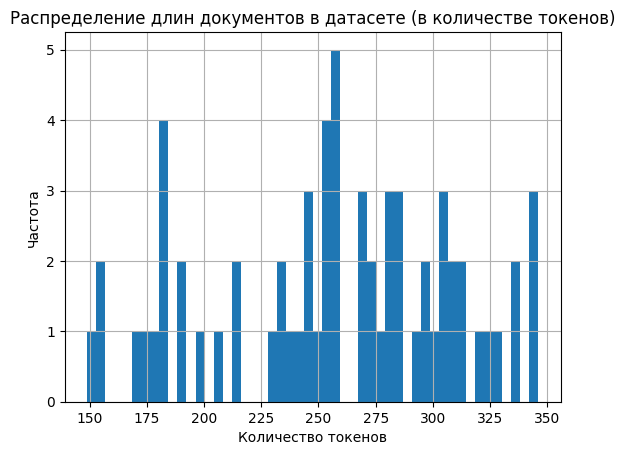

In [33]:
import pandas as pd
from transformers import AutoTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt

# Загрузите ваш датасет
df = pd.read_csv("llava_outputs.csv")

# Инициализируйте токенайзер
MODEL_NAME = 'thenlper/gte-small'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Вычислите длины документов в токенах
lengths = [len(tokenizer.encode(text)) for text in tqdm(ddf)]

# Постройте распределение длин документов
fig = pd.Series(lengths).hist(bins=50)
plt.title("Распределение длин документов в датасете (в количестве токенов)")
plt.xlabel("Количество токенов")
plt.ylabel("Частота")
plt.show()


In [35]:
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

In [37]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    add_start_index=True,
    strip_whitespace=True,
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for text in ddf:
    doc = LangchainDocument(page_content=text)
    docs_processed += text_splitter.split_documents([doc])


In [38]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [56]:
# Embed a user query in the same space
user_query = "Where can I find chair. Give me an image path to it"
query_vector = embedding_model.embed_query(user_query)

In [41]:
!pip install plotly

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 49.9 MB/s eta 0:00:00a 0:00:01


In [57]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

/home/altair/miniconda3/envs/rag/lib/python3.10/site-packages/pacmap/pacmap.py:822: UserWarning:




In [58]:
docs_processed[0]

Document(metadata={'start_index': 0}, page_content='Image path is /mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00000.jpg. Here is the short description of it: In the image, I see a whiteboard mounted on a wall with various diagrams and equations written on it. The whiteboard is positioned to the left of the frame, and it appears to be the main focus of the image. To the right of the whiteboard, there is a black trash can. The trash can is standing on the floor, and it is positioned in front of a white cabinet. The cabinet is closed and appears to be of a standard design, likely used for storage. The floor beneath these objects is a dark color, providing a contrast to the whiteboard and cabinet. The overall scene suggests an office or classroom setting.')

In [59]:
docs_processed

[Document(metadata={'start_index': 0}, page_content='Image path is /mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00000.jpg. Here is the short description of it: In the image, I see a whiteboard mounted on a wall with various diagrams and equations written on it. The whiteboard is positioned to the left of the frame, and it appears to be the main focus of the image. To the right of the whiteboard, there is a black trash can. The trash can is standing on the floor, and it is positioned in front of a white cabinet. The cabinet is closed and appears to be of a standard design, likely used for storage. The floor beneath these objects is a dark color, providing a contrast to the whiteboard and cabinet. The overall scene suggests an office or classroom setting.'),
 Document(metadata={'start_index': 0}, page_content='Image path is /mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00252.jpg. Here is the short description of it: The image shows an in

In [49]:
%matplotlib notebook

In [50]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            #"source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [60]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='Where can I find chair. Give me an image path to it'...

==================================Top document==================================
Image path is /mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/01060.jpg. Here is the short description of it: The image shows an interior space that appears to be a waiting area or a lobby. There are several chairs arranged in a semi-circle around a central table. The chairs are upholstered in a dark red fabric, and the table is a light-colored wood with a visible grain pattern. The flooring is a dark gray carpet, and the walls are painted in a light beige color.

In the background, there is a large white wall that extends to the ceiling, which is not visible in the image. On the right side of the image, there is a partial view of a person sitting at the table, but only the back of their head and shoulders are visible.
==================================Metadata================================

In [61]:
len(retrieved_docs)

5

In [62]:
for doc_top_i, doc in enumerate(retrieved_docs):
    print(
    f"\n================================== Document #{doc_top_i} =================================="
    )
    print(doc.page_content)
    print("====================================================================")


================================== Document #0 ==================================
Image path is /mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/01060.jpg. Here is the short description of it: The image shows an interior space that appears to be a waiting area or a lobby. There are several chairs arranged in a semi-circle around a central table. The chairs are upholstered in a dark red fabric, and the table is a light-colored wood with a visible grain pattern. The flooring is a dark gray carpet, and the walls are painted in a light beige color.

In the background, there is a large white wall that extends to the ceiling, which is not visible in the image. On the right side of the image, there is a partial view of a person sitting at the table, but only the back of their head and shoulders are visible.

================================== Document #1 ==================================
Image path is /mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_imag

In [54]:
READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [63]:
simple_answer = READER_LLM(user_query)
print(simple_answer[0]['generated_text'])

.

I'm sorry but I don't have access to images or specific locations. However, you can search for "chair" on a search engine like google and you will find many images of chairs from various sources. You can then save the image to your computer or device and use it in your project as needed. Remember to always ensure that any images used are properly licensed and attributed if necessary.


In [64]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



In [65]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]
# We only need the text of the documents

context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question=user_query, context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Based on the descriptions provided, we can infer that all of the images contain chairs. However, if you are specifically looking for an image with the keyword "chair," Document 2 (image path: /mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00466.jpg) would be the best option as it has a row of six pink chairs lined up against a wall. This image can be found in the dataset mentioned in the context.


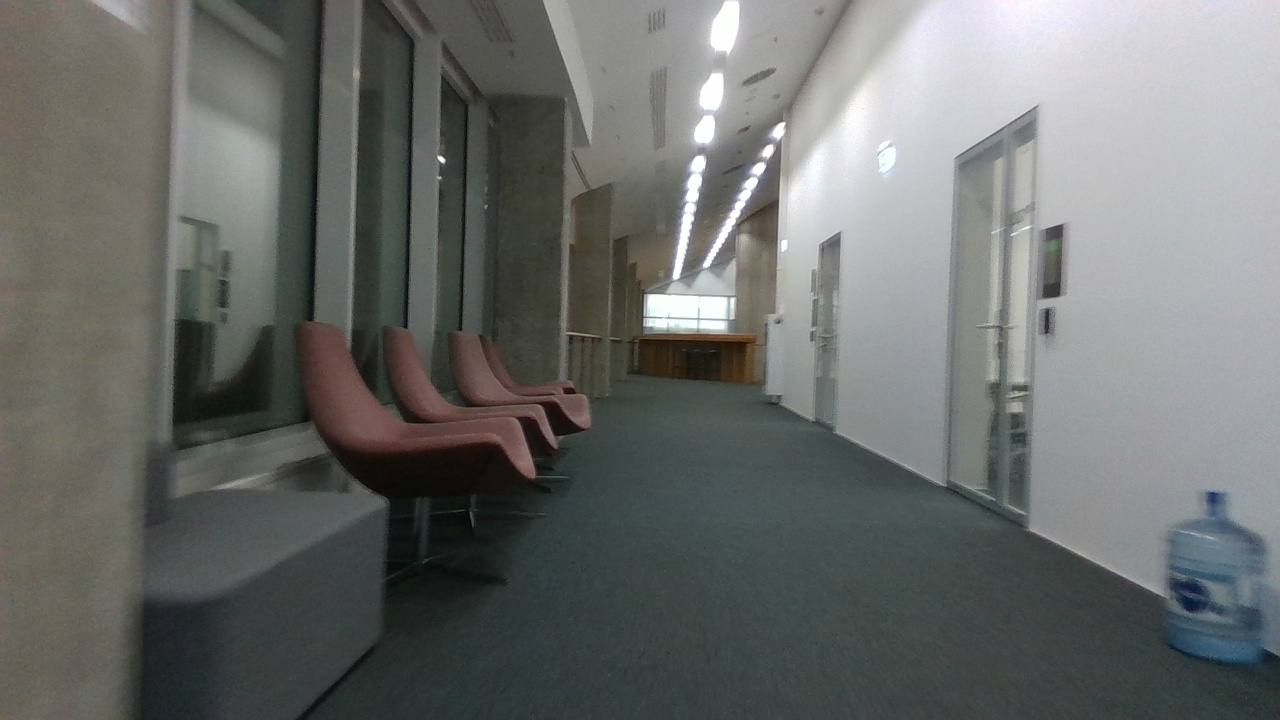

In [67]:
import PIL

image = PIL.Image.open("/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00466.jpg")
image.show()